In [20]:
!pip install pandas numpy matplotlib seaborn scikit-learn eli5

--- Phase 1: Data Preparation and Cleaning ---
Dataset loaded successfully.
Initial shape: (7043, 21)

--- Initial Data Exploration ---

First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Ye

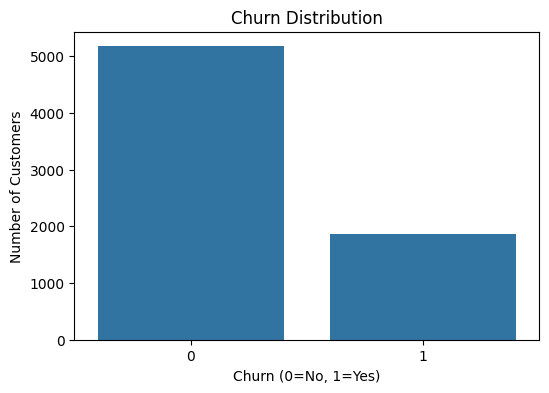

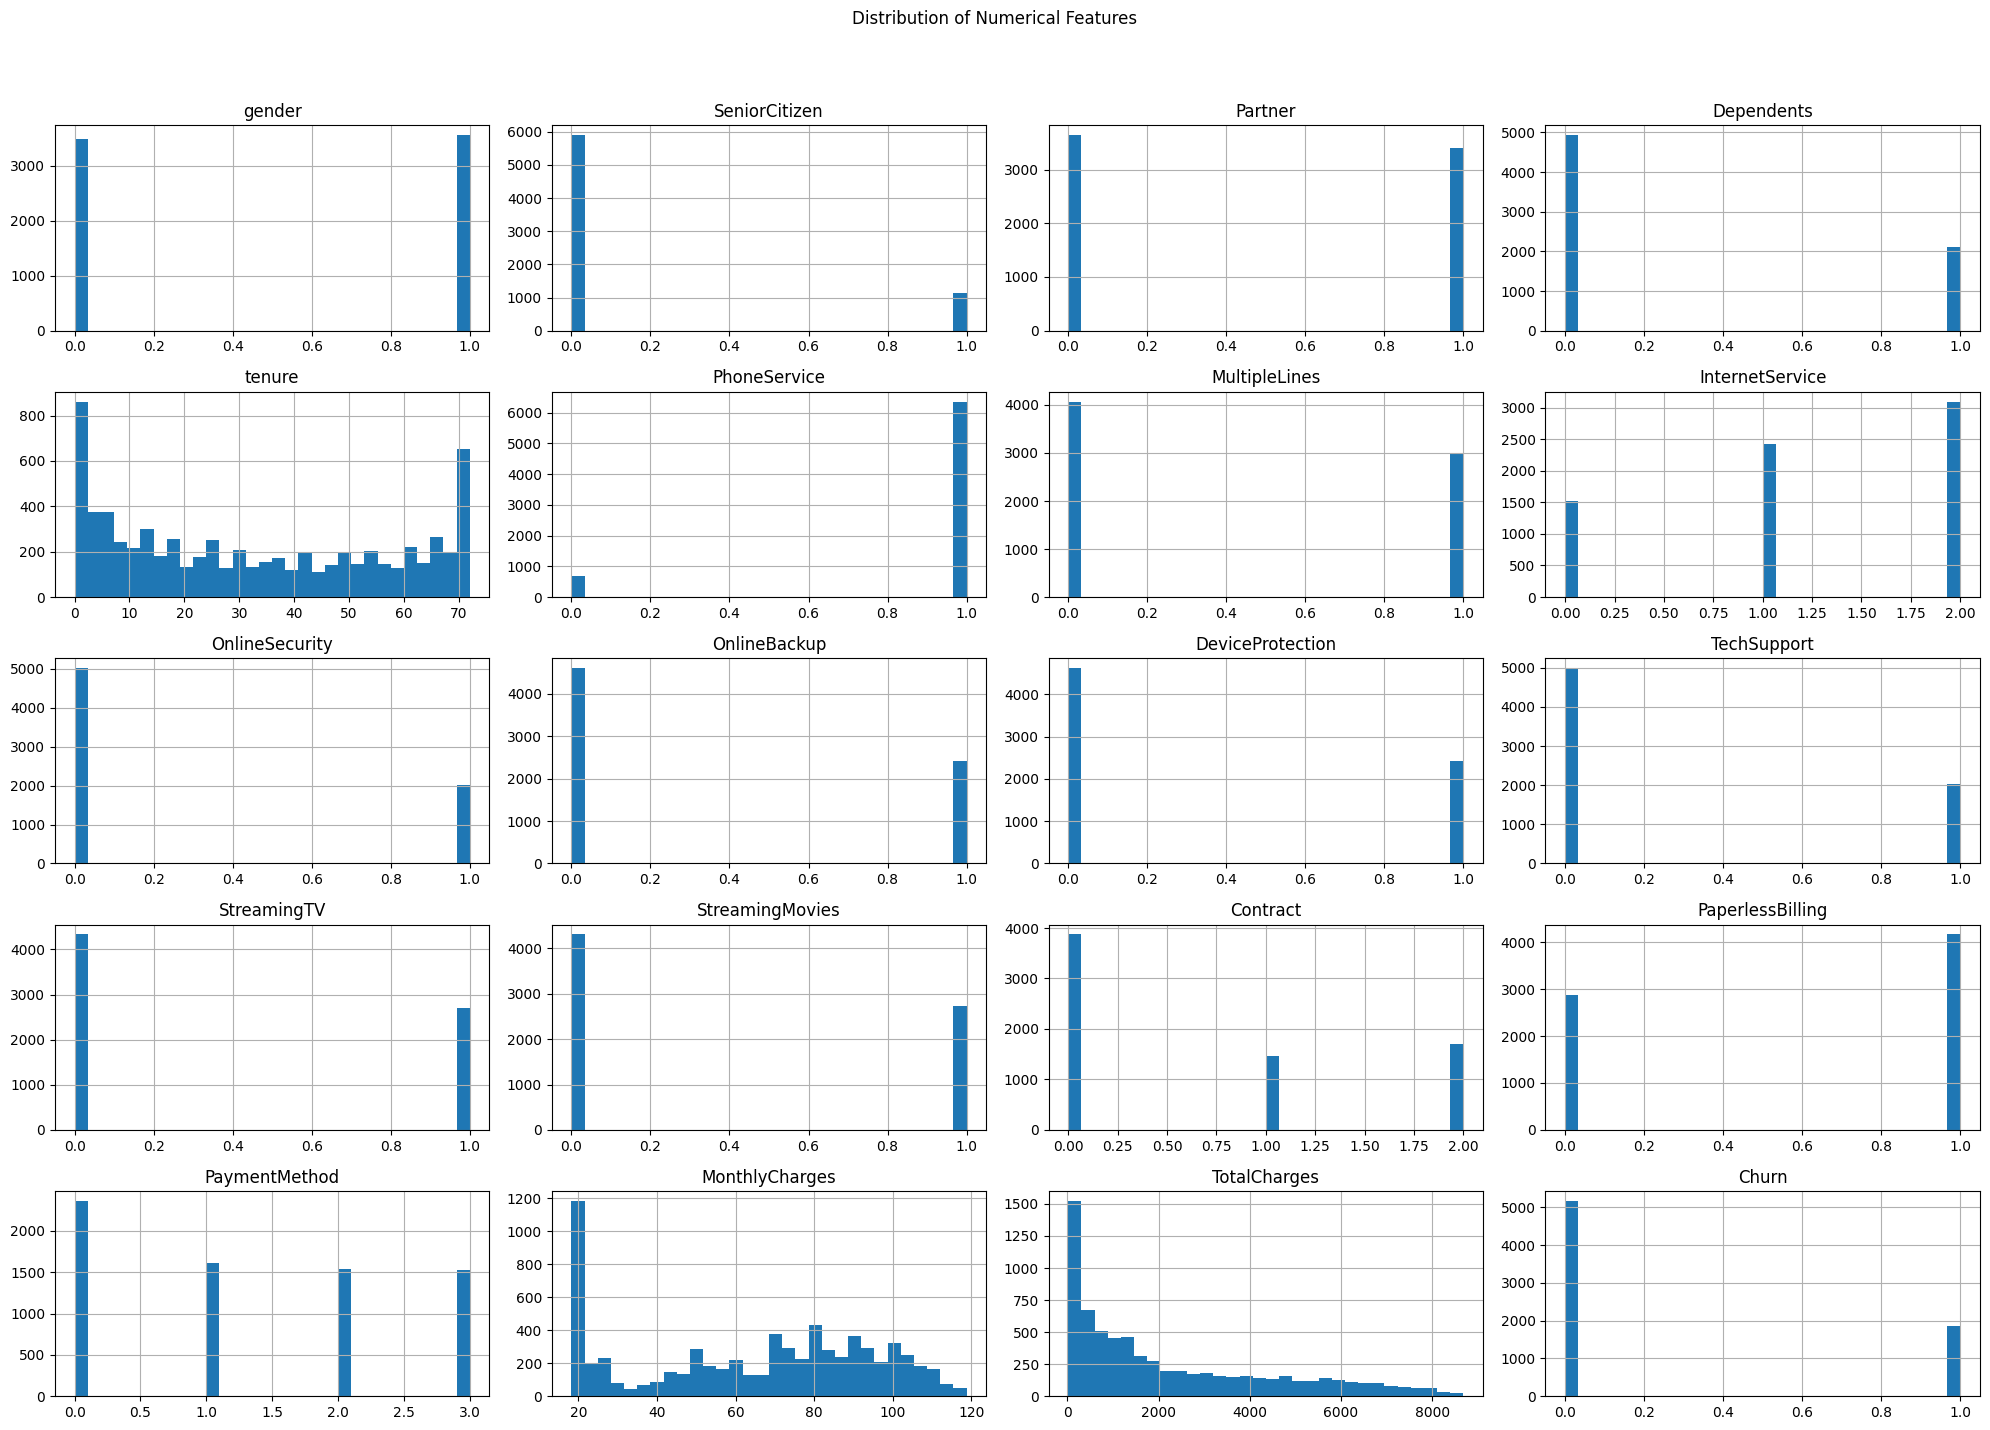

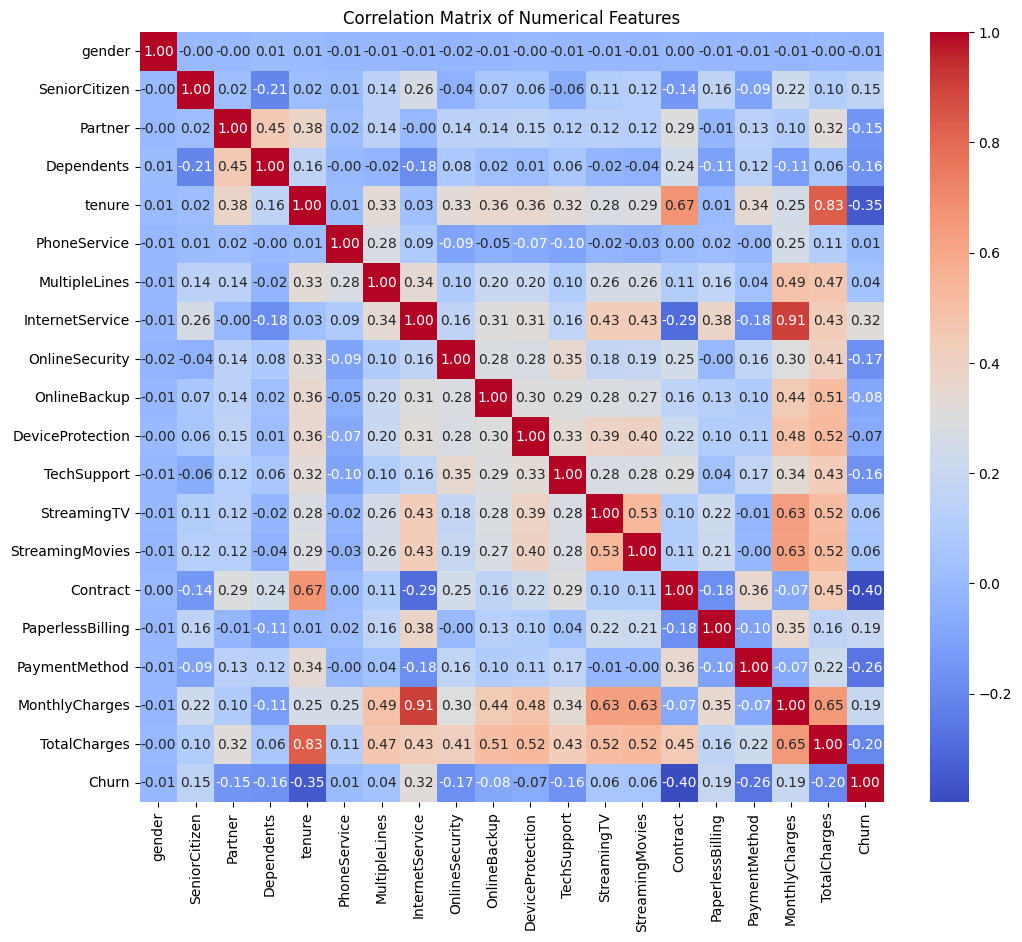


--- Phase 3: Model Building and Evaluation ---

--- Diagnostic: X DataFrame Info before Preprocessor Setup ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 n

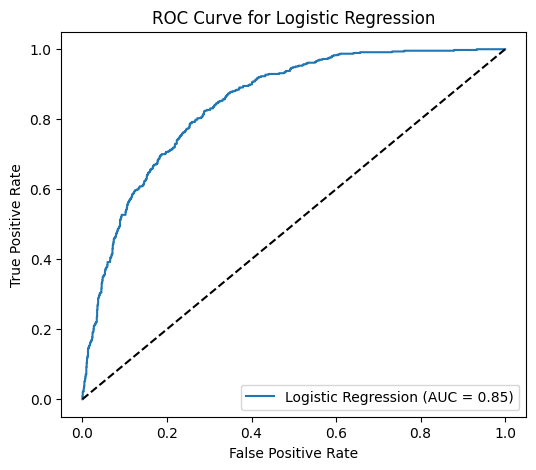


--- Training Random Forest ---
Random Forest Metrics:
  Accuracy: 0.7973
  Precision: 0.6519
  Recall: 0.5054
  F1-Score: 0.5694
  ROC AUC: 0.8339
  Confusion Matrix:
[[1168  126]
 [ 231  236]]


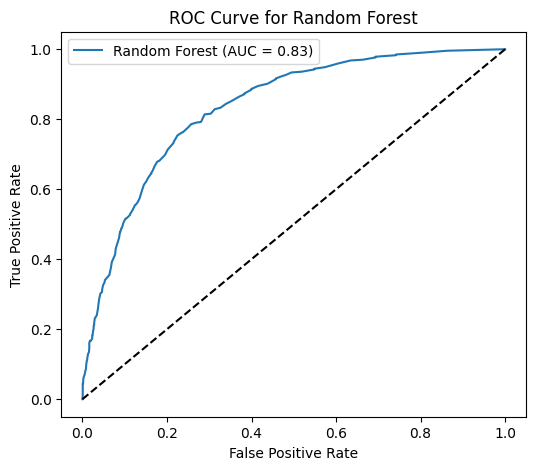


--- Training Gradient Boosting ---
Gradient Boosting Metrics:
  Accuracy: 0.7990
  Precision: 0.6583
  Recall: 0.5032
  F1-Score: 0.5704
  ROC AUC: 0.8461
  Confusion Matrix:
[[1172  122]
 [ 232  235]]


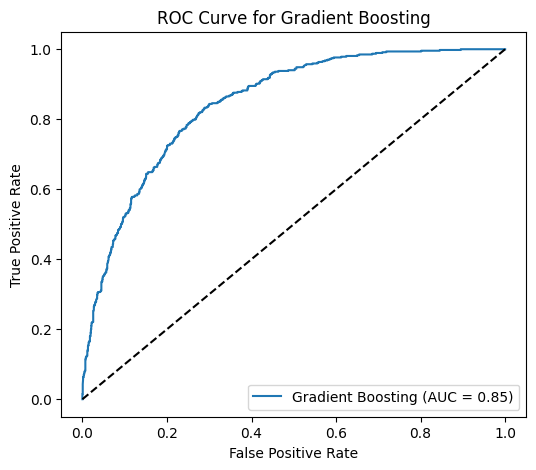


--- Cross-validation for Random Forest Classifier ---
Random Forest Cross-validation ROC AUC scores: [0.83349867 0.83484073 0.80818543 0.81514551 0.82431035]
Mean CV ROC AUC: 0.8232

--- Phase 4: Model Explainability (ELI5) ---

--- Permutation Importance for Random Forest Classifier ---


Weight,Feature
0.0286 ± 0.0099,tenure
0.0215 ± 0.0113,InternetService
0.0160 ± 0.0133,Contract
0.0149 ± 0.0017,MonthlyCharges
0.0106 ± 0.0035,MultipleLines
0.0103 ± 0.0077,TotalCharges
0.0078 ± 0.0054,PaymentMethod
0.0062 ± 0.0033,SeniorCitizen
0.0058 ± 0.0072,Partner
0.0044 ± 0.0017,TechSupport



--- Phase 5: Customer Segmentation ---

Customer Segment Distribution:
customer_segment
Stable                     2509
At Risk                    1776
Low Value Loyal            1172
New & Potentially Loyal     919
Loyal                       667
Name: count, dtype: int64

Churn Rate per Segment:
Churn                            0          1
customer_segment                             
At Risk                   7.770270  92.229730
Low Value Loyal          99.232082   0.767918
Loyal                    96.401799   3.598201
New & Potentially Loyal  92.165397   7.834603
Stable                   94.978079   5.021921

Average Churn Probability per Segment:
customer_segment
At Risk                    0.789071
Low Value Loyal            0.022381
Loyal                      0.078861
New & Potentially Loyal    0.164668
Stable                     0.100897
Name: churn_probability, dtype: float64

--- Characterizing Customer Segments ---

Segment: New & Potentially Loyal
           gender  Senior

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import eli5
from eli5.sklearn import PermutationImportance


import warnings
warnings.filterwarnings('ignore')

# --- Phase 1: Data Preparation and Cleaning ---

print("--- Phase 1: Data Preparation and Cleaning ---")

# 1. Load the dataset
try:
    df = pd.read_csv('Telecom_Churn_Prediction.csv')
    print("Dataset loaded successfully.")
    print(f"Initial shape: {df.shape}")
except FileNotFoundError:
    print("Error: Telecom_Churn_Prediction.csv not found. Please make sure the file is in the correct directory.")
    exit()

# 2. Initial Data Exploration
print("\n--- Initial Data Exploration ---")
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nMissing values before cleaning:")
print(df.isnull().sum())

print("\nDescriptive Statistics for numerical columns:")
print(df.describe())

print("\nChurn Rate:")
churn_rate = df['Churn'].value_counts(normalize=True) * 100
print(f"No Churn: {churn_rate[0]:.2f}%")
print(f"Churn: {churn_rate[1]:.2f}%")

# 3. Data Cleaning
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

if 'gender' in df.columns and df['gender'].dtype == 'object':
    df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
    print("\n'gender' column explicitly converted: Male=1, Female=0.")


binary_cols_to_map = [
    'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

for col in binary_cols_to_map:
    if col in df.columns and df[col].dtype == 'object':
        unique_vals = df[col].unique()
        if 'Yes' in unique_vals or 'No' in unique_vals:
            mapping = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0}
            df[col] = df[col].map(mapping)
            # Fill any remaining NaNs after mapping if original column had other values
            if df[col].isnull().any():
                df[col].fillna(0, inplace=True) # Default to 0 if an unmapped value caused NaN
            print(f"'{col}' column explicitly converted: Yes=1, No/No service=0.")

# --- Handle 'InternetService' column with label encoding (0, 1, 2) ---
if 'InternetService' in df.columns and df['InternetService'].dtype == 'object':
    # Define a specific order for mapping, e.g., 'No' as 0, 'DSL' as 1, 'Fiber optic' as 2
    internet_service_mapping = {'No': 0, 'DSL': 1, 'Fiber optic': 2}
    df['InternetService'] = df['InternetService'].map(internet_service_mapping)
    # Fill any NaNs that might result from unmapped values, e.g., if there were other unexpected strings
    if df['InternetService'].isnull().any():
        df['InternetService'].fillna(0, inplace=True) # Default to 'No' (0) if problematic
    print("\n'InternetService' column explicitly converted: No=0, DSL=1, Fiber optic=2.")

# --- Handle 'Contract' column with label encoding (0, 1, 2) ---
if 'Contract' in df.columns and df['Contract'].dtype == 'object':
    # Define a specific order for mapping based on contract length
    contract_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
    df['Contract'] = df['Contract'].map(contract_mapping)
    # Fill any NaNs that might result from unmapped values
    if df['Contract'].isnull().any():
        df['Contract'].fillna(0, inplace=True) # Default to 'Month-to-month' (0) if problematic
    print("\n'Contract' column explicitly converted: Month-to-month=0, One year=1, Two year=2.")

# --- New: General handling for any remaining object (string) columns using Label Encoding ---
# This will catch 'PaymentMethod' and any other unhandled string columns
print("\n--- General Label Encoding for remaining Object columns ---")
for col in df.columns:
    if df[col].dtype == 'object':
        # Exclude 'Churn' if it's still an object at this point (though it's handled below)
        if col != 'Churn':
            original_unique_values = df[col].unique()
            df[col], unique_numerical_labels = pd.factorize(df[col])
            print(f"'{col}' column converted using pd.factorize(). Original values: {list(original_unique_values)} -> Numeric labels assigned.")

# -------------------------------------------------------------------

# Fill missing numerical values with median
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median_val}")

# Fill missing categorical values with mode
# After the general label encoding, this section might not be strictly necessary for object columns.
# However, keeping it for robustness in case any non-standard object columns remain.
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in '{col}' with mode: {mode_val}")

print("\nMissing values after cleaning:")
print(df.isnull().sum().sum()) # Should be 0 if all handled

# Convert 'Churn' column to numerical (if not already 0/1)
# Assuming 'Yes' for churn and 'No' for no churn
if 'Churn' in df.columns and df['Churn'].dtype == 'object':
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    print("\n'Churn' column converted to numerical (1=Yes, 0=No).")

# Drop customerID if it exists and is not a feature
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)
    print("Dropped 'customerID' column.")

print(f"Shape after cleaning: {df.shape}")
print("\nCleaned Dataset Info (after all cleaning and conversions):")
df.info() # Re-print info after all cleaning to verify dtypes

# --- Phase 2: Exploratory Data Analysis (EDA) ---

print("\n--- Phase 2: Exploratory Data Analysis (EDA) ---")

# Visualize Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Number of Customers')
plt.show()

# Distribution of numerical features
df.hist(bins=30, figsize=(20, 15))
plt.suptitle('Distribution of Numerical Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Categorical features vs. Churn
# This loop should now ideally not find any 'object' columns if all were converted.
for column in df.select_dtypes(include='object').columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=column, hue='Churn', data=df)
    plt.title(f'{column} vs. Churn')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Correlation Matrix for numerical features
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# --- Phase 3: Model Building and Evaluation ---

print("\n--- Phase 3: Model Building and Evaluation ---")

# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Diagnostic: Print X DataFrame Info before Preprocessor Setup
print("\n--- Diagnostic: X DataFrame Info before Preprocessor Setup ---")
X.info()

# Identify categorical and numerical features for preprocessing
# After general label encoding, most/all features should now be numerical.
categorical_features = X.select_dtypes(include='object').columns
numerical_features = X.select_dtypes(include=np.number).columns

# Diagnostic: Print identified features for preprocessing
print("\n--- Diagnostic: Features Identified for Preprocessing ---")
print(f"Numerical Features ({len(numerical_features)}): {list(numerical_features)}")
print(f"Categorical Features ({len(categorical_features)}): {list(categorical_features)}")


# Create preprocessing pipelines for numerical and categorical features
# If categorical_features is empty, the 'cat' transformer will effectively be skipped.
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # This might not be needed if all categorical columns are encoded numerically

# Only include the 'cat' transformer if there are actual categorical features left
transformers_list = [('num', numerical_transformer, numerical_features)]
if len(categorical_features) > 0:
    transformers_list.append(('cat', categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers_list)


# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Create a pipeline for each model
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', model)])
             for name, model in models.items()}

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")

results = {}
for name, pipeline in pipelines.items():
    print(f"\n--- Training {name} ---")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] # Probability of churn

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

    print(f"{name} Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Confusion Matrix:\n{cm}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend()
    plt.show()

# Example of Cross-validation (e.g., with Random Forest)
print("\n--- Cross-validation for Random Forest Classifier ---")
cv_scores = cross_val_score(pipelines['Random Forest'], X, y, cv=5, scoring='roc_auc')
print(f"Random Forest Cross-validation ROC AUC scores: {cv_scores}")
print(f"Mean CV ROC AUC: {cv_scores.mean():.4f}")

# --- Phase 4: Model Explainability (ELI5) ---

print("\n--- Phase 4: Model Explainability (ELI5) ---")

# Let's pick Random Forest for explainability as it generally performs well.
# ELI5 works best with a trained model and preprocessed data.
# We need to get feature names after one-hot encoding for ELI5.

# Re-evaluate all_feature_names based on current preprocessing strategy
# If categorical_features is empty, then ohe_feature_names will be empty.
if len(categorical_features) > 0:
    ohe_feature_names = pipelines['Random Forest'].named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = list(numerical_features) + list(ohe_feature_names)
else:
    all_feature_names = list(numerical_features) # All features are now numerical

# Permutation Importance
# This measures how much the model's accuracy decreases when a feature is randomly shuffled.
# A larger drop indicates higher importance.

print("\n--- Permutation Importance for Random Forest Classifier ---")
perm = PermutationImportance(pipelines['Random Forest'], random_state=42).fit(X_test, y_test)
eli5_display = eli5.show_weights(perm, feature_names=all_feature_names)
display(eli5_display) # Displays in Jupyter Notebook

# If you prefer SHAP (uncomment and install if needed: pip install shap)
# print("\n--- SHAP Explanations for Random Forest Classifier ---")
# # For tree-based models like Random Forest
# explainer = shap.TreeExplainer(pipelines['Random Forest'].named_steps['classifier'])
# # Use preprocessed X_test
# X_test_processed = pipelines['Random Forest'].named_steps['preprocessor'].transform(X_test)
# shap_values = explainer.shap_values(X_test_processed)

# # Summary plot
# shap.summary_plot(shap_values[1], X_test_processed, feature_names=all_feature_names) # For churn class (1)
# # Individual prediction explanation (e.g., first churn prediction in test set)
# churn_idx = y_test[y_test == 1].index[0]
# churn_customer_data = X_test_processed[X_test.index.get_loc(churn_idx)]
# shap.force_plot(explainer.expected_value[1], shap_values[1][X_test.index.get_loc(churn_idx)], churn_customer_data, feature_names=all_feature_names)


# --- Phase 5: Customer Segmentation ---

print("\n--- Phase 5: Customer Segmentation ---")

# Predict churn probability for all customers in the original dataframe
# Using the best performing model (e.g., Random Forest)
df_segment = df.copy() # Work on a copy
df_segment['churn_probability'] = pipelines['Random Forest'].predict_proba(X)[:, 1]

# Define churn thresholds (these can be adjusted based on business context)
churn_threshold = 0.5 # Default classification threshold

# Create segments based on churn probability and other hypothetical metrics
# For this example, let's assume 'MonthlyCharges' and 'Tenure' are indicators of engagement/value

# You'll need to define what constitutes 'high engagement', 'low engagement', etc.
# These thresholds are illustrative and should be defined by domain expertise.

# Example thresholds for demonstration
monthly_charges_high_threshold = df_segment['MonthlyCharges'].quantile(0.75)
monthly_charges_low_threshold = df_segment['MonthlyCharges'].quantile(0.25)
tenure_high_threshold = df_segment['tenure'].quantile(0.75)
tenure_low_threshold = df_segment['tenure'].quantile(0.25)


def segment_customer(row):
    if row['churn_probability'] >= churn_threshold:
        return 'At Risk'
    elif row['tenure'] >= tenure_high_threshold and row['MonthlyCharges'] >= monthly_charges_high_threshold:
        return 'Loyal'
    elif row['tenure'] <= tenure_low_threshold and row['churn_probability'] < churn_threshold:
        return 'New & Potentially Loyal' # Or 'Promising New'
    elif row['MonthlyCharges'] <= monthly_charges_low_threshold and row['churn_probability'] < churn_threshold:
        return 'Low Value Loyal'
    else:
        return 'Stable' # Customers not fitting other clear categories

df_segment['customer_segment'] = df_segment.apply(segment_customer, axis=1)

print("\nCustomer Segment Distribution:")
print(df_segment['customer_segment'].value_counts())

print("\nChurn Rate per Segment:")
print(df_segment.groupby('customer_segment')['Churn'].value_counts(normalize=True).unstack() * 100)

print("\nAverage Churn Probability per Segment:")
print(df_segment.groupby('customer_segment')['churn_probability'].mean())

# Characterize segments
print("\n--- Characterizing Customer Segments ---")
for segment in df_segment['customer_segment'].unique():
    print(f"\nSegment: {segment}")
    segment_df = df_segment[df_segment['customer_segment'] == segment]
    print(segment_df.describe())
    # You can also print value counts for categorical features within each segment
    # Note: After label encoding all original object columns, this loop might not find any.
    # If any remain, they would be printed here.
    for col in df.select_dtypes(include='object').columns:
        print(f"\n{col} distribution in {segment} segment:")
        print(segment_df[col].value_counts(normalize=True) * 100)

# --- Deliverables: Final Recommendations (Conceptual) ---

print("\n--- Phase 6: Final Recommendations (Conceptual Outline) ---")

print("\nBased on the analysis, here's a conceptual outline for final recommendations:")
print("This part would typically be elaborated in your PowerPoint report.")

# Recommendations would be derived from:
# 1.  **Feature Importance:** Which features highly influence churn?
#     (e.g., 'tenure', 'MonthlyCharges', 'Contract', 'InternetService_Fiber optic')
# 2.  **Segment Characteristics:** What defines each segment and their churn risk?

print("\n**Recommendations for 'At Risk' Customers (High Churn Probability):**")
print("-   Personalized outreach with attractive retention offers (e.g., discounts, upgraded plans, loyalty bonuses).")
print("-   Proactive customer service to address pain points identified by important features (e.g., slow internet, frequent issues).")
print("-   Analyze specific service usage and tailor solutions (e.g., if 'Fiber optic' is a churn driver, improve its reliability).")
print("-   Targeted campaigns focusing on contract renewal incentives (e.g., for 'Month-to-month' contracts).")

print("\n**Recommendations for 'Loyal' Customers (Low Churn Probability, High Value/Engagement):")
print("-   Reward programs and exclusive benefits to reinforce loyalty.")
print("-   Early access to new services or features.")
print("-   Upselling/cross-selling opportunities for complementary services.")
print("-   Regular check-ins to ensure satisfaction.")

print("\n**Recommendations for 'New & Potentially Loyal' Customers:**")
print("-   Onboarding programs to ensure a smooth start and address early issues.")
print("-   Proactive communication about service benefits and support channels.")
print("-   Monitor engagement closely in initial months.")

print("\n**Recommendations for 'Low Value Loyal' / 'Dormant' Customers:**")
print("-   Re-engagement campaigns with attractive offers to increase usage or upgrade plans.")
print("-   Understanding reasons for low usage (e.g., do they use competitor services?).")
print("-   Consider cost-effective retention strategies or re-acquisition campaigns if they churn.")

print("\n**General Actionable Strategies based on Feature Importance:**")
print("-   **Contract Type:** Encourage longer-term contracts (e.g., 1-year, 2-year) with incentives, as month-to-month customers churn more.")
print("-   **Internet Service:** Address issues with Fiber Optic internet if it's a significant churn driver; ensure consistent high-quality service.")
print("-   **Tenure:** Implement early warning systems for customers with short tenure, as they are more prone to churn.")
print("-   **Monthly Charges:** Analyze if high monthly charges are perceived as not offering value; consider tiered pricing or value-added services.")
print("-   **Customer Service Interactions:** Improve service quality if 'complaints' or related features show up as important.")
print("-   **Payment Method:** Investigate if certain payment methods correlate with churn (e.g., electronic check).")

print("\n**Data-Driven Decision Making:**")
print("-   Continuously monitor churn rate and model performance.")
print("-   Regularly retrain the model with fresh data.")
print("-   A/B test different retention strategies.")

print("\n--- End of Python Analysis ---")